In [177]:
class Config:
    def __init__(self):
        pass

def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import adam_v2
from keras import backend as K

%matplotlib inline

columns_train = ['tavg', 'rh_avg', 'rr', 'ff_avg']
# columns_train = ['Open', 'High', 'Low', 'Close', 'Adj Close']

config = set_config({
    "input_size": columns_train.__len__(),
    "seq_len": 14,
    "batch_size": 256,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": True,
    "learning_rate": 0.01,
    "max_epochs": 30,
    "time_col": 'tanggal',
    # "time_col": 'Date',
    "prediction_col": columns_train[2],
    'much_day_predict': 10 + 1,
    'validation_split': 0.1,
    'suffle': False,
})

usecols = [config.time_col] + columns_train

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [96]:
dataset_train = pd.read_csv('../Assets/Data/1985-2021.csv', usecols=usecols).replace(to_replace=[8888, 9999, 2555], value=np.nan)
# dataset_train = pd.read_csv('../Assets/Data/GOOG.csv')

datelist_train = list(dataset_train[config.time_col])
datelist_train = [datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(columns_train))

Training set shape == (13028, 5)
All timestamps == 13028
Featured selected: ['tavg', 'rh_avg', 'rr', 'ff_avg']


In [97]:
dataset_train = dataset_train[columns_train]
dataset_train.interpolate(inplace=True)

# dataset_train = dataset_train[columns_train].astype(str)
# for i in columns_train:
#     for j in range(0, len(dataset_train)):
#         dataset_train[i][j] = dataset_train[i][j].replace(',', '')

# dataset_train = dataset_train.astype(float)

training_set = dataset_train.values
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (13028, 4).


In [98]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 2:3])

array([[0.        ],
       [0.08950617],
       [0.        ],
       ...,
       [0.        ],
       [0.03842593],
       [0.07685185]])

In [99]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = config.much_day_predict   # Number of days we want top predict into the future
n_past = config.seq_len     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 2])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (13005, 14, 3).
y_train shape == (13005, 1).


In [100]:
model = Sequential()

model.add(LSTM(units=config.hidden_size, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(config.dropout))
model.add(Dense(units=config.output_size, activation='linear'))

model.compile(optimizer = adam_v2.Adam(learning_rate=config.learning_rate), loss=root_mean_squared_error)
# model.compile(optimizer = adam_v2.Adam(learning_rate=config.learning_rate), loss='mean_squared_error')

In [101]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard('logs')
# callbacks = [es, rlr, mcp, tb]
callbacks = [es, rlr]

history = model.fit(X_train, y_train, shuffle=config.suffle, epochs=config.max_epochs, callbacks=callbacks, validation_split=config.validation_split, verbose=1, batch_size=config.batch_size)

Epoch 1/30
46/46 [==============================] - 15s 110ms/step - loss: 0.0823 - val_loss: 0.0711 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 3s 64ms/step - loss: 0.0760 - val_loss: 0.0687 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 4s 81ms/step - loss: 0.0759 - val_loss: 0.0685 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 3s 59ms/step - loss: 0.0750 - val_loss: 0.0689 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 3s 58ms/step - loss: 0.0750 - val_loss: 0.0687 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 3s 59ms/step - loss: 0.0749 - val_loss: 0.0689 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 3s 60ms/step - loss: 0.0750 - val_loss: 0.0690 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 3s 69ms/step - loss: 0.0749 - val_loss: 0.0686 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 3s 60ms/step - loss: 0.0748 - val_loss: 0.0683 - l

In [102]:
history.history['loss']

[0.0822623074054718,
 0.07598959654569626,
 0.07591700553894043,
 0.07499633729457855,
 0.07502895593643188,
 0.07493630051612854,
 0.07495113462209702,
 0.07488706707954407,
 0.07480928301811218,
 0.07461583614349365,
 0.07473358511924744,
 0.07478554546833038,
 0.0744943767786026,
 0.07431388646364212,
 0.07429597526788712,
 0.07427193969488144,
 0.07439760863780975,
 0.07449370622634888,
 0.07441765815019608,
 0.07426952570676804,
 0.0742649957537651,
 0.07423413544893265,
 0.07422669976949692]

In [103]:
model.evaluate(X_train, y_train, callbacks=callbacks, verbose=1, batch_size=config.batch_size)

51/51 [==============================] - 1s 24ms/step - loss: 0.0751


0.07510838657617569

In [154]:
# Generate list of sequence of days for predictions
# datelist_future = pd.date_range((datelist_train[-1] + datetime.timedelta(days=1)), periods=n_future, freq='1d').tolist()
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [155]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [190]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[config.prediction_col]).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[config.prediction_col]).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTIONS_FUTURE

,rr
2021-12-31,20.968603
2022-01-01,20.907274
2022-01-02,20.600414
2022-01-03,21.434532
2022-01-04,22.766701
2022-01-05,22.846689
2022-01-06,25.287983
2022-01-07,26.353153
2022-01-08,25.614944
2022-01-09,24.251471


In [255]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=columns_train)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

START_DATE_FOR_PLOTTING = (datelist_train[-1] - timedelta(days=60)).strftime("%Y-%m-%d")

In [256]:
import json

new_histori = dataset_train.loc[START_DATE_FOR_PLOTTING:].reset_index().copy()
new_histori.rename(columns={new_histori['index'].name: config.time_col}, inplace=True)
new_histori[config.time_col] = new_histori[config.time_col].map(lambda x: x.strftime('%Y-%m-%d'))

new_train = PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].reset_index().copy()
new_train.rename(columns={new_train['index'].name: config.time_col}, inplace=True)
new_train[config.time_col] = new_train[config.time_col].map(lambda x: x.strftime('%Y-%m-%d'))

new_future = PREDICTIONS_FUTURE.reset_index().copy()
new_future.rename(columns={new_future['index'].name: config.time_col}, inplace=True)
new_future[config.time_col] = new_future[config.time_col].map(lambda x: x.strftime('%Y-%m-%d'))


jsonFile = open("dataFrame.json", "w")
jsonFile.write(json.dumps({
    'histori': new_histori.to_dict('records'),
    'train': new_train.to_dict('records'),
    'future': new_future.to_dict('records')
}))
jsonFile.close()

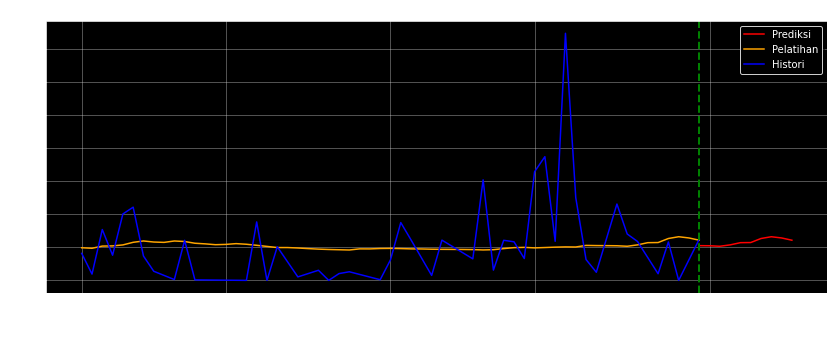

In [257]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[config.prediction_col], color='r', label='Prediksi')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][config.prediction_col], color='orange', label='Pelatihan')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:][config.prediction_col], color='b', label='Histori')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Prediksi dan Histori Curah Hujan', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Tingkat Curah Hujan', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()